In [3]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.isotonic import IsotonicRegression
from sklearn import ensemble
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from sklearn import impute
from sklearn import preprocessing
from sklearn import compose
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from rfpimp import *

In [4]:
data = pd.read_csv('train.csv')

### EDA

In [5]:
# Removing records which have less than 10_000 Revenue
data = data.loc[data['revenue']>10_000]

X = data[['budget', 'genres', 'original_language', 'popularity', 'production_companies', 'release_date', 'runtime']]
y = data['revenue']

### Helper functions for preprocessings

In [7]:
def get_age(df, col_name):
    """ 
    Creates a column for age using a column consisting of dates
    
    Input: dataframe, input column name
    Output : None, dataframe modifications done in place
    """
    
    df['current_day'] = pd.to_datetime('today')
    df[col_name+'-age']  = (df['current_day'] - pd.to_datetime(df[col_name])).dt.days
    df.drop(['current_day'],axis=1, inplace=True)
    
def get_genre_list (genres):
    """ 
    Extract genres from the given string
    
    Input: String
    Output : List of strings
    """
    
    res = []
    if not genres or pd.isnull(genres):
        return res
    genres = genres.replace('[','').replace(']','')
    genre_list = genres.split('},')
    for item in genre_list:
        res.append(int(item.split(',')[0].replace("{'id': ", '')))
    return res

def get_counts(df,col_name):
    """
    Gets counts of elements from a flattened list of the given column in the dataframe
    
    Input: dataframe, column name
    Output: Counter Object
    """
    
    x = []
    for j in df[col_name]:
        x.append(j)
    return Counter(sum(x,[]))

def get_unique(df,col_name):
    """
    Gets list of unique elements from a flattened list of the given column in the dataframe
    
    Input: dataframe, column name
    Output: List
    """
    x = set()
    for j in df[col_name]:
        x = x.union(j)
    return list(x)

def n_hot_encode(df,col_name, val_list=None):
    """
    Given a column consisting of lists of elements, creates columns for each unique element of the flattened list,
    if particular element exists in the column for a row, the row entry for the column of that element is marked as 1
    
    eg:
    if flattened list of genres = ['comedy', 'drama', 'thriller']
    if row value = ['comedy', 'drama']
    
    for the given row,
    genre_0 = 1, genre_1 = 1, genre_2 = 0 (column name genre_0 stands for comedy, genre_1 for drama, genre_2 for thriller)
    
    
    Input: dataframe, column name, (optional) value list : list of unique element values to create new columns for
    Output: None, dataframe modifications done in place
    """
    
    if(not val_list):
        val_list = get_unique(df, col_name) 
    for i in range(len(val_list)):
        df[col_name+str(i)] = 0
    for index, row in df.iterrows():
        for elm in df[col_name][index]:
            if( elm in val_list):
                df[col_name+str(val_list.index(elm))][index] = 1

def get_prod_id_list(prod):
    """ 
    Extract production company ID from the given string
    
    Input: String
    Output : List of strings
    """
    
    res = []
    if not prod or pd.isnull(prod):
        return res
    prod = prod.replace('[{','').replace('}]','')
    prod_list = prod.split('},')
    for item in prod_list:
        res.append(int(item.split(',')[-1].replace("'id': ", '')))
    return res

def get_prod_list_names(prod):
    """ 
    Extract production company names from the given string
    
    Input: String
    Output : List of strings
    """
    
    res = []
    if not prod or pd.isnull(prod):
        return res
    prod = prod.replace('[{','').replace('}]','')
    prod_list = prod.split('},')
    for item in prod_list:
        res.append(int(item.split(',')[-1].replace("'name': ", '')))
    return res

def get_list_of_casts(df, col):
    """ 
    Get list of cast members in all movies
    
    Input: dataframe, column name
    Output : List of strings
    """
    cast_list = []
    for index, row in df.iterrows():
        cast_dict_list = eval(df[col][index])
        for idx in range(len(cast_dict_list)):
            cast_list.append(cast_dict_list[idx]['name'])
    return cast_list

def create_popular_cast_counter(df, col, casts, n):
    """
    Creates a column counting the number of popular cast memebers in movie
    
    
    """
    most_popular = Counter(casts).most_common(n)
    df['pop_cast'] = 0
    for index, row in df.iterrows():
        cast_dict_str = df[col][index]
        for cast in most_popular:
            if cast[0] in cast_dict_str:
                df['pop_cast'][index] = df['pop_cast'][index] + 1

def create_dump_month_identifier(df, col):
    """
    Creates column to identify whether movie was released in a dump month
    
    Input: dataframe, column name
    Output : None, dataframe modifications done in place
    """
    df[col] = pd.to_datetime(df[col])
    df[col+'_month'] = df[col].dt.month
    df['dump_month_identifier'] = 0
    for index, row in df.iterrows():
        if df[col+'_month'][index] in [1,2,8,9]:
            df['dump_month_identifier'][index] = 1   
    df.drop([col+'_month'],axis=1,inplace=True)

def create_language_order_dict(df, col_name):
    """
    Creates a dictionary of genres and their position in a ranking by average revenue by language
    
    eg:
    if comedy revenue = $134 million
    if thriller revenue = $70 million
    if action revenue = $85 million
    
    dictionary output:
    {
        "comedy": 0,
        "thriller": 2,
        "action": 1
    }
    
    Input: dataframe, language column name
    Output : dictionary of genres mapped with their positions
    """
    
    language_order = df.groupby([col_name]).mean().reset_index()[[col_name, 'revenue']].sort_values(by='revenue', ascending=False)
    language_order_dict = {}
    languages = list(language_order[col_name])
    for i in range(len(languages)):
        language_order_dict[languages[i]] = i
    return language_order_dict

def get_language_position(language):
    """
    Returns position of given language in list of languages ordered by average revenue
    
    Input: language
    Output : position of l
    """
    language_order_dict = create_language_order_dict(data, 'original_language')
    return language_order_dict[language]

### Preprocessing

In [8]:
#preprocess genres
X['genre_list'] = X['genres'].apply(get_genre_list)
n_hot_encode(X,'genre_list')
X.drop(['genre_list','genres'], axis=1, inplace=True)

#get age from release date
get_age(X, 'release_date')
#create_dump_month_identifier(X, 'release_date')
X.drop(['release_date'],axis=1,inplace=True)

#preprocess production companies
X['prod_comp_list'] = X['production_companies'].apply(get_prod_id_list)
val_list = [x[0] for x in get_counts(X,'prod_comp_list').most_common(20)]
n_hot_encode(X,'prod_comp_list', val_list)
X.drop(['production_companies', 'prod_comp_list'],axis=1,inplace=True)

# Encoding original_language
X['original_language'] = X['original_language'].apply(get_language_position)

C:\Users\siddi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\siddi\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\siddi\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

### Modelling

#### Baseline: Ridge Regression Model

#### Using RMSE as metric

In [9]:
def rmlse(target_true, target_predicted):
    """
    Root Mean Squared Logarithmic Error
    Input: True response values, predicted response values
    Output: The computed root mean squared logarithmic error
    """
    assert len(target_true) == len(target_predicted), "True and predicted targets need to be the same length"
    log_diff = np.log(target_predicted + 1) - np.log(target_true + 1)
    return np.sqrt(np.mean(np.power(log_diff, 2)))

#### Splitting the data into train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

In [11]:
def make_pipelines(df_cols):
    """Creates pipeline for each of the following algorithms:
    1. Ridge Regression
    2. K-nearest Neighbors Regressor
    3. BayesianRidge
    4. Random Forest™
    5. XGBoost
    If appropriate, apply StandardScaler before the algorithm.
    Use default hyperparameters.
    If an algorithm takes random_state then random_state=42
    - Create a numerical feature transformer.
    - Create a preprocessor
    - Create a pipeline for each of the above given algorithms with StandardScalar(if applied), and preprocessors.
    Input: Dataframe columns
    Output: A list of all the pipelines.
    """
    numeric_features = list(df_cols)
    numeric_transformer = Pipeline(steps=[('imputer', impute.SimpleImputer(strategy='median', missing_values=np.nan))])
    preprocessor = compose.ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])
    pipelines = [Pipeline(steps=[('preprocessor', preprocessor),('scaler', preprocessing.StandardScaler()),('reg', Ridge(normalize = True))])]
    pipelines.append(Pipeline(steps=[('preprocessor', preprocessor),('scaler', preprocessing.StandardScaler()),('reg', KNeighborsRegressor())]))
    pipelines.append(Pipeline(steps=[('preprocessor', preprocessor),('scaler', preprocessing.StandardScaler()),('reg', BayesianRidge())]))
    pipelines.append(Pipeline(steps=[('preprocessor', preprocessor),('reg', RandomForestRegressor(random_state = 42))]))
    pipelines.append(Pipeline(steps=[('preprocessor', preprocessor),('xgb', XGBRegressor(seed = 42))]))
    return pipelines

In [12]:
def make_pipeline_model_eval(df_cols, regressor = None):
    """
    - Create a numerical feature transformer.
    - Create a preprocessor
    - Create a pipeline for the given regressor with StandardScalar(if applied), and preprocessor.
    Input: Dataframe columns
    Output: A list of all the pipelines.
    """
    numeric_transformer = Pipeline(steps=[('imputer', impute.SimpleImputer(strategy='median', missing_values=np.nan)), \
                                          ('scaler', preprocessing.StandardScaler())])
    preprocessor = compose.ColumnTransformer(transformers=[('num', numeric_transformer, list(df_cols))])
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),('regressor', regressor)])
    return pipeline

In [13]:
pipelines = make_pipelines(X_train.columns)

for pipe in pipelines:
    pipe.fit(X_train, y_train)
    
for pipe in pipelines:
    name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    y_pred = pipe.predict(X_val)
    r2score = round(r2_score(y_val, y_pred), 2)
    rmlse_score = round(rmlse(y_val, y_pred), 2)
    medae_value = round(median_absolute_error(y_val,y_pred), 2)
    print(f"\nFor {name:<22}\n r2_score:{r2score}, rmlse:{rmlse_score}, medae:{medae_value}")

C:\Users\siddi\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,



For Ridge                 
 r2_score:0.39, rmlse:2.12, medae:28641948.4

For KNeighborsRegressor   
 r2_score:0.33, rmlse:1.99, medae:26153653.2

For BayesianRidge         
 r2_score:-0.01, rmlse:2.8, medae:57678196.83

For RandomForestRegressor 
 r2_score:0.32, rmlse:1.75, medae:19903380.95

For XGBRegressor          
 r2_score:0.17, rmlse:1.59, medae:22591860.0


C:\Users\siddi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
C:\Users\siddi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


### Hyper parameter tuning

In [14]:
cv=8
n_iter=30

In [15]:
def make_random_cv():
    """
    Steps:
    1. Define Estimator
    2. Define hyperparameter search space
    3. Instantiate RandomizedSearchCV
    Output: RandomizedSearchCV object fit on the training data
    """
    rdfr = RandomForestRegressor(random_state = 42)
    
    # Number of trees in random forest
    n_estimators = [20,40,45,50,60,80,100,150,200, 300, 500, 600, 700, 800]
    
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt', 20, 25, 30, 35]
    
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10, 15]
    
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4, 8, 10]
    

    hyperparameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
    
    clf_random_cv = RandomizedSearchCV(rdfr, 
                              hyperparameters, 
                              cv=cv, 
                              n_iter=n_iter)
    print(clf_random_cv)
    return clf_random_cv

In [16]:
#Metric values after parameter tuning
cv = make_random_cv()
final_model = make_pipeline_model_eval(X_train.columns, cv)
final_model.fit(X_train,y_train)
y_pred = final_model.predict(X_val)
r2score = round(r2_score(y_val, y_pred),2)
rmlse_score = round(rmlse(y_val, y_pred), 2)
medae_value = round(median_absolute_error(y_val, y_pred), 2)
print(f"After parameter tuning, r2_score:{r2score}, rmlse:{rmlse_score}, medae:{medae_value}")

RandomizedSearchCV(cv=8, estimator=RandomForestRegressor(random_state=42),
                   n_iter=30,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 20, 25,
                                                         30, 35],
                                        'min_samples_leaf': [1, 2, 4, 8, 10],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [20, 40, 45, 50, 60, 80,
                                                         100, 150, 200, 300,
                                                         500, 600, 700, 800]})
After parameter tuning, r2_score:0.47, rmlse:1.82, medae:18802452.14


### Feature importance visualization

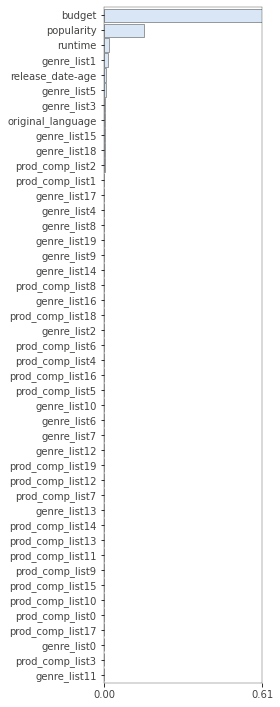

In [17]:
imp = importances(final_model, X_test, y_test, n_samples=-1)
viz = plot_importances(imp)
viz.view()

In [18]:
y_pred = final_model.predict(X_test)
r2score = round(r2_score(y_test, y_pred),2)
rmlse_score = round(rmlse(y_test, y_pred), 2)
medae_value = round(median_absolute_error(y_test, y_pred), 2)
print(f"Model performance on test data , r2_score:{r2score}, rmlse:{rmlse_score}, medae:{medae_value}")

Model performance on test data , r2_score:0.73, rmlse:1.9, medae:17521021.5
